# Testing LOSD
### Bevölkerung nach Zivilstand, Geschlecht, Alter und Stadtquartier

Zivilstand der Bevölkerung nach Geschlecht, Alter und Stadtquartier, seit 1993.
https://data.integ.stadt-zuerich.ch/dataset/bev331od3310 

Datum: 26.03.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DonGoginho/colab/blob/main/losd/3310_losd_bev_bestand_jahr_quartier_zivilstand_ag_geschl_od3310.ipynb)


### Importiere die notwendigen Packages

In [1]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly

In [2]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

Importiere die eigenen Funktionen, die unter ../0_scripts abegelegt sind:

In [3]:
import sys
sys.path.append('../0_scripts')

import my_py_dataviz_functions as mypy_dv
import my_py_dataloading_functions as mypy_dl

In [4]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [5]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

### Settings
Definiere Settings. 
Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen)

In [6]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

#### Zeitvariabeln

In [7]:
#Zeitvariabeln als Strings:
now = datetime.date.today()
year_today = now.strftime("%Y")
date_today = "_"+now.strftime("%Y-%m-%d")

#Zeitvariabeln als Integers:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Daten importieren und Metadaten checken

- status: int / prod
- data_source: web / ld / dropzone
- datums_attr: beschreibt das oder die Datumsfelder, die als Datum geparsed werden sollen. Falls es keines gibt: None

**BITTE HIER ANPASSEN**

In [8]:
package_name = "bev331od3310"

In [9]:
data2betested = mypy_dl.load_data(
    status = 'int'
    , data_source = 'ld'
    , package_name = package_name
    , dataset_name = "bev331od3310.csv"    
    , datums_attr = ['ZEIT_LANG']
    )

fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/BEV331OD3310/observation?format=csv


 **Überprüfe die Metadaten:**

 **Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bev331od3310 

 **View auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/BEV331OD3310 

Es ist ein Fehler aufgetreten: No columns to parse from file


Error: No columns to parse from file



In [10]:
data2betested.head(2)

AttributeError: 'NoneType' object has no attribute 'head'

Berechne weitere Attribute falls notwendig

In [ ]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr = lambda x: x.ZEIT_LANG,
        StichtagDatJahr_str = lambda x: x.ZEIT_LANG.astype(str),
        Jahr = lambda x: x.ZEIT_LANG.dt.year,
        #Jahr_nbr = lambda x: x.ZEIT_CODE.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.RAUM_CODE.str[-3:].astype(int),

    )
    .sort_values('ZEIT_LANG', ascending=False)
    )
data2betested.head(2)

AttributeError: Can only use .str accessor with string values!

Zeitbereich aus den Daten:

In [ ]:
data_max_date = str(max(data2betested.ZEIT_LANG).year)
data_min_date = str(min(data2betested.ZEIT_LANG).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von nan und ein Maximumjahr von nan


Temp speichere die csv-Datei, da es immer wieder zu Ausfällen kommt. So kann ich mal den Report fertig bauen.

In [ ]:
docname = package_name +date_today+".csv"
print(docname)


In [ ]:
data2betested.to_csv('./saved_data/sprint_a_'+docname, index=False)

### Einfache Datentests

In [ ]:
data2betested.head(2).T

,140898,300136
ZEIT_LANG,2022-12-31 00:00:00,2022-12-31 00:00:00
ZEIT_CODE,Z31122022,Z31122022
RAUM_LANG,Alt-Wiedikon,Friesenberg
RAUM_CODE,R00031,R00033
ALT_LANG,42 Jahre alt,46 Jahre alt
ALT_CODE,ALT0042,ALT0046
SEX_LANG,weiblich,männlich
SEX_CODE,SEX0002,SEX0001
ZIV_LANG,Ledig,Verheiratet
ZIV_CODE,ZIV0001,ZIV0003


In [ ]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 562329 entries, 140898 to 0
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ZEIT_LANG            562329 non-null  datetime64[ns]
 1   ZEIT_CODE            562329 non-null  object        
 2   RAUM_LANG            562329 non-null  object        
 3   RAUM_CODE            562329 non-null  object        
 4   ALT_LANG             562329 non-null  object        
 5   ALT_CODE             562329 non-null  object        
 6   SEX_LANG             562329 non-null  object        
 7   SEX_CODE             562329 non-null  object        
 8   ZIV_LANG             562329 non-null  object        
 9   ZIV_CODE             562329 non-null  object        
 10  BEW                  562329 non-null  float64       
 11  KREISEZH_LANG        562329 non-null  object        
 12  KREISEZH_CODE        562329 non-null  object        
 13  StichtagDatJahr    

In [ ]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 562,329 rows (observations) and 17 columns (variables).


There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei BEW?

In [ ]:
data2betested[np.isnan(data2betested.BEW)]

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,ALT_LANG,ALT_CODE,SEX_LANG,...,BEW,KREISEZH_LANG,KREISEZH_CODE,StichtagDatJahr,StichtagDatJahr_str,Jahr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [ ]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [ ]:
data2betested.index.year.unique()

Index([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype='int32', name='StichtagDatJahr')

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [ ]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

No categorical data in dataset.


Beschreibe numerische Attribute

In [ ]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,BEW,Jahr,RAUM_my_sort
count,"562,329","562,329","562,329"
mean,21,"2,008",67
std,31,9,35
min,0,"1,993",11
25%,3,"2,000",34
50%,9,"2,008",71
75%,25,"2,015",101
max,379,"2,022",123


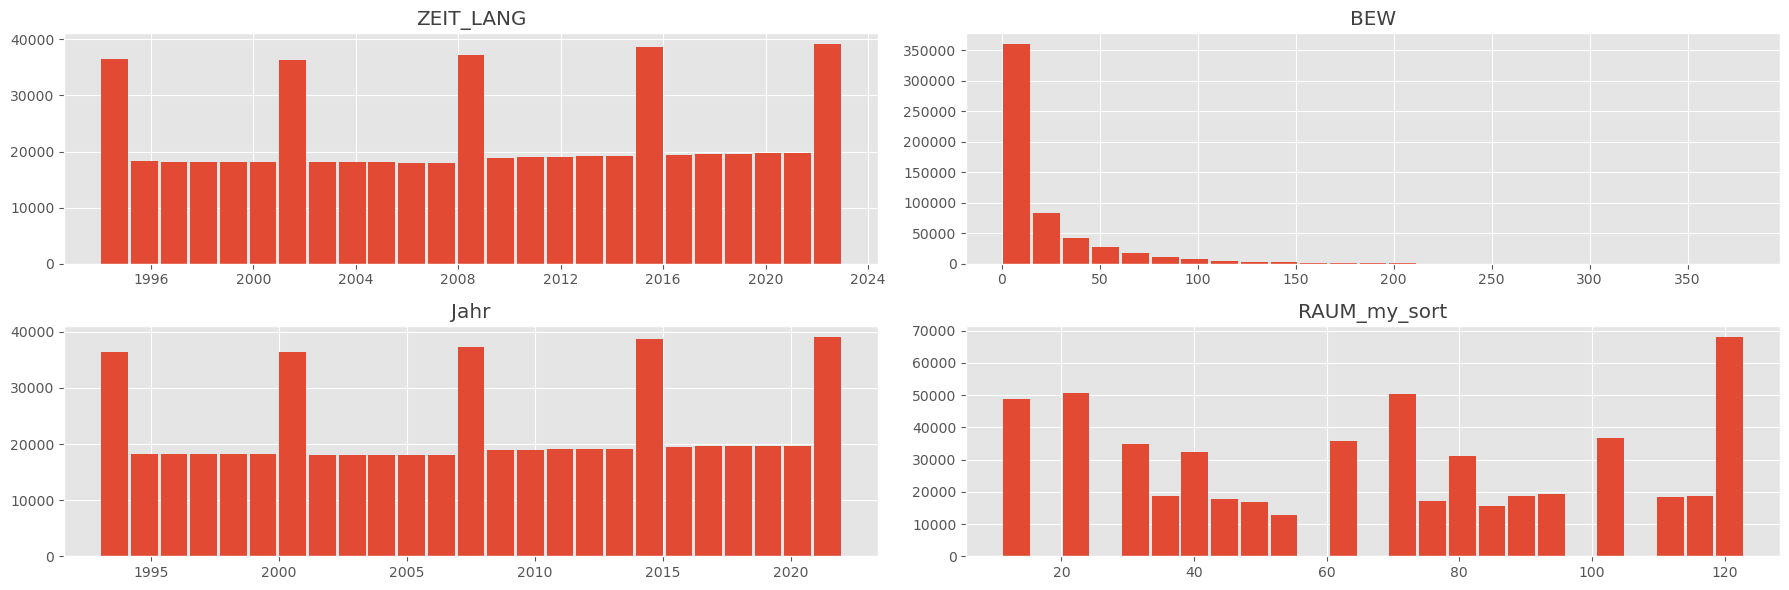

In [ ]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [ ]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,ALT_LANG,ALT_CODE,SEX_LANG,...,ZIV_CODE,BEW,KREISEZH_LANG,KREISEZH_CODE,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,,,,,,


### Nullwerte und Missings?

In [ ]:
data2betested.isnull().sum()

ZEIT_LANG              0
ZEIT_CODE              0
RAUM_LANG              0
RAUM_CODE              0
ALT_LANG               0
ALT_CODE               0
SEX_LANG               0
SEX_CODE               0
ZIV_LANG               0
ZIV_CODE               0
BEW                    0
KREISEZH_LANG          0
KREISEZH_CODE          0
StichtagDatJahr_str    0
Jahr                   0
RAUM_my_sort           0
dtype: int64

In [ ]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno
#msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [ ]:
agg_jahr = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('Jahr', ascending=False) 
agg_jahr.reset_index().head(3)

,Jahr,sum_AnzBestWir
0,2022,443037
1,2021,436332
2,2020,434736


In [ ]:
agg_Quarts = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['RAUM_my_sort', 'ZEIT_LANG', 'RAUM_CODE']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('RAUM_CODE', ascending=False) 
agg_Quarts.reset_index().head(50)

,RAUM_my_sort,ZEIT_LANG,RAUM_CODE,sum_AnzBestWir
0,123,2022-12-31,R00123,12920
1,123,2007-12-31,R00123,11343
2,123,1993-12-31,R00123,10834
3,123,1994-12-31,R00123,10895
4,123,1995-12-31,R00123,10995
5,123,1996-12-31,R00123,10990
6,123,1997-12-31,R00123,11013
7,123,1998-12-31,R00123,11015
8,123,1999-12-31,R00123,11119
9,123,2000-12-31,R00123,11281


In [ ]:
agg_Alt = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['ALT_LANG', 'ALT_CODE',]) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('ALT_CODE', ascending=False) 
agg_Alt.reset_index()

,ALT_LANG,ALT_CODE,sum_AnzBestWir
0,111 Jahre alt,ALT0111,1
1,110 Jahre alt,ALT0110,0
2,109 Jahre alt,ALT0109,3
3,108 Jahre alt,ALT0108,5
4,107 Jahre alt,ALT0107,12
...,...,...,...
107,4 Jahre alt,ALT0004,102434
108,3 Jahre alt,ALT0003,106628
109,2 Jahre alt,ALT0002,111309
110,1 Jahr alt,ALT0001,117277


In [ ]:
agg_Alt = data2betested.loc[data_max_date]\
    .groupby(['SEX_LANG','SEX_CODE',]) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('SEX_CODE', ascending=False) 
agg_Alt.reset_index()

,SEX_LANG,SEX_CODE,sum_AnzBestWir
0,weiblich,SEX0002,220721
1,männlich,SEX0001,222316


In [ ]:
agg_Ziv = data2betested.loc[data_max_date]\
    .groupby(['ZIV_LANG', 'ZIV_CODE',]) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('ZIV_CODE', ascending=False) 
agg_Ziv.reset_index()

,ZIV_LANG,ZIV_CODE,sum_AnzBestWir
0,Unbekannt,ZIV0099,84
1,Aufgelöste Partnerschaft,ZIV0007,543
2,In eingetragener Partnerschaft,ZIV0006,1880
3,Geschieden,ZIV0005,35853
4,Verwitwet,ZIV0004,13996
5,Verheiratet,ZIV0003,132504
6,Ledig,ZIV0001,258177


In [ ]:
agg_Kreise = data2betested.loc[data_max_date]\
    .groupby(['KREISEZH_LANG', 'KREISEZH_CODE']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('KREISEZH_CODE', ascending=True) 
agg_Kreise.reset_index()

,KREISEZH_LANG,KREISEZH_CODE,sum_AnzBestWir
0,Kreis 2 (ab 1893),R00200,37049
1,Kreis 3 (ab 1915),R00600,50582
2,Kreis 4 (ab 1915),R00700,29672
3,Kreis 5 (ab 1915),R00800,15888
4,Kreis 8 (ab 1915),R01100,17814
5,Kreis 6 (ab 1934),R01200,35862
6,Kreis 7 (ab 1934),R01300,39301
7,Kreis 9 (ab 1934),R01400,58517
8,Kreis 10 (ab 1934),R01500,41505
9,altes Quartier Schwamendingen (1934-1969); Kre...,R01700,32953


### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [ ]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,ALT_LANG,ALT_CODE,SEX_LANG,...,ZIV_CODE,BEW,KREISEZH_LANG,KREISEZH_CODE,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,,,,,,
2022-12-31,2022-12-31,Z31122022,Leimbach,R00023,97 Jahre alt,ALT0097,weiblich,...,ZIV0004,1,Kreis 2 (ab 1893),R00200,2022-12-31,2022,23
2022-12-31,2022-12-31,Z31122022,Friesenberg,R00033,33 Jahre alt,ALT0033,männlich,...,ZIV0003,27,Kreis 3 (ab 1915),R00600,2022-12-31,2022,33


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnbevölkerung seit ...

In [ ]:
data2betested.reset_index().columns

Index(['StichtagDatJahr', 'ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'ALT_LANG',
       'ALT_CODE', 'SEX_LANG', 'SEX_CODE', 'ZIV_LANG', 'ZIV_CODE', 'BEW', 'KREISEZH_LANG',
       'KREISEZH_CODE', 'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [ ]:
myAgg1 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAgg1.reset_index().tail(4)

,StichtagDatJahr,sum_WBev
26,1996-12-31,359648
27,1995-12-31,360826
28,1994-12-31,360848
29,1993-12-31,360898


In [ ]:
grafik1 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg1.reset_index().query('sum_WBev>3')
    ,x = 'StichtagDatJahr:T'
    ,x_beschriftung = 'Jahr'
    ,y = 'sum_WBev:Q'
    ,y_beschriftung = 'Anz. Personen'
    ,category=''
    ,category_beschriftung='Legend'
    ,warning_status = "always" #always or ignore
    ,myTitle="Bevölkerungsentwicklung, seit "+str(data2betested.index.year.min())
)

In [ ]:
grafic_name = package_name+"_alt1_total"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik1.save('grafiken_testing/'+grafic_name)

alt.LayerChart(...)

#### Entwicklung Wohnbevölkerung nach Stadtquartier seit ...

In [ ]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'ALT_LANG', 'ALT_CODE', 'SEX_LANG',
       'SEX_CODE', 'ZIV_LANG', 'ZIV_CODE', 'BEW', 'KREISEZH_LANG', 'KREISEZH_CODE',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [ ]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg2 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg2.reset_index().head(2)

,StichtagDatJahr,RAUM_LANG,RAUM_CODE,sum_WBev
0,1993-12-31,Affoltern,R00111,18095
1,1993-12-31,Mühlebach,R00082,5694


In [ ]:
grafik2 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg2.reset_index().query('sum_WBev>30')
    ,x = 'StichtagDatJahr:T'
    ,x_beschriftung = 'Jahr'
    ,y = 'sum_WBev:Q'
    ,y_beschriftung = 'Anz. Personen'
    ,category = "RAUM_LANG:N"
    ,category_beschriftung= 'Stadtquartier:'
    ,warning_status = "ignore" #always or ignore
    ,myTitle="Bevölkerung nach Stadtquartier, seit "+str(data2betested.index.year.min())
)

In [ ]:
grafic_name = package_name+"_alt2_raum_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik2.save('grafiken_testing/'+grafic_name)

alt.LayerChart(...)

#### Entwicklung Wohnbevölkerung nach Zivilstand 

In [ ]:
myAgg3 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'ZIV_LANG', 'ZIV_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg3.reset_index().head(5)


,StichtagDatJahr,ZIV_LANG,ZIV_CODE,sum_WBev
0,1993-12-31,Geschieden,ZIV0005,26975
1,1993-12-31,Ledig,ZIV0001,155209
2,1993-12-31,Verheiratet,ZIV0003,151993
3,1993-12-31,Verwitwet,ZIV0004,26721
4,1994-12-31,Geschieden,ZIV0005,27240


In [ ]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'ALT_LANG', 'ALT_CODE', 'SEX_LANG',
       'SEX_CODE', 'ZIV_LANG', 'ZIV_CODE', 'BEW', 'KREISEZH_LANG', 'KREISEZH_CODE',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [ ]:
grafik3 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg3.reset_index().query('RAUM_my_sort < 100')
    ,x = 'StichtagDatJahr:T'
    ,x_beschriftung = 'Jahr'
    ,y = 'sum_WBev:Q'
    ,y_beschriftung = 'Anz. Personen'
    ,category = "ZIV_LANG:N"
    ,category_beschriftung= 'Zivilstand:'
    ,warning_status = "ignore" #always or ignore
    ,myTitle="Entwicklung Wohnbevölkerung nach Zivilstand, seit "+str(data2betested.index.year.min())
)
grafik3

In [ ]:
grafic_name = package_name+"_alt3_ziv_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik3.save('grafiken_testing/'+grafic_name)

#### Entwicklung der Wohnbevölkerung nach Geschlecht

In [ ]:
myAgg4 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'SEX_LANG','SEX_CODE', ]) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg4.reset_index().head(5)


,StichtagDatJahr,SEX_LANG,SEX_CODE,sum_WBev
0,1993-12-31,männlich,SEX0001,172002
1,1993-12-31,weiblich,SEX0002,188896
2,1994-12-31,männlich,SEX0001,172309
3,1994-12-31,weiblich,SEX0002,188539
4,1995-12-31,männlich,SEX0001,172441


In [ ]:
grafik4 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg4.reset_index().query('RAUM_my_sort < 100')
    ,x = 'StichtagDatJahr:T'
    ,x_beschriftung = 'Jahr'
    ,y = 'sum_WBev:Q'
    ,y_beschriftung = 'Anz. Personen'
    ,category = "SEX_LANG:N"
    ,category_beschriftung= 'Geschlecht:'
    ,warning_status = "ignore" #always or ignore
    ,myTitle="Entwicklung Wohnbevölkerung nach Geschlecht, seit "+str(data2betested.index.year.min())
)
grafik4

In [ ]:
grafic_name = package_name+"_alt4_geschl_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik4.save('grafiken_testing/'+grafic_name)

#### Entwicklung der Wohnbevölkerung nach Alter

In [ ]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg5 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'ALT_LANG', 'ALT_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg5.reset_index().head(5)


,StichtagDatJahr,ALT_LANG,ALT_CODE,sum_WBev
0,1993-12-31,0 Jahre alt,ALT0000,3291
1,1993-12-31,73 Jahre alt,ALT0073,3410
2,1993-12-31,72 Jahre alt,ALT0072,3417
3,1993-12-31,71 Jahre alt,ALT0071,3484
4,1993-12-31,70 Jahre alt,ALT0070,3575


In [ ]:
grafik5 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg4.reset_index()
    ,x = 'StichtagDatJahr:T'
    ,x_beschriftung = 'Jahr'
    ,y = 'sum_WBev:Q'
    ,y_beschriftung = 'Anz. Personen'
    ,category = "ALT_LANG:N"
    ,category_beschriftung= 'Alter:'
    ,warning_status = "ignore" #always or ignore
    ,myTitle="Entwicklung Wohnbevölkerung nach Alter, seit "+str(data2betested.index.year.min())
)
grafik5

In [ ]:
grafic_name = package_name+"_alt4_alter_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik5.save('grafiken_testing/'+grafic_name)

#### Barcharts mit Seaborn

In [ ]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2018":data_max_date]\
    .groupby(['StichtagDatJahr','Jahr', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

In [ ]:
#help(sns.catplot)     

In [ ]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

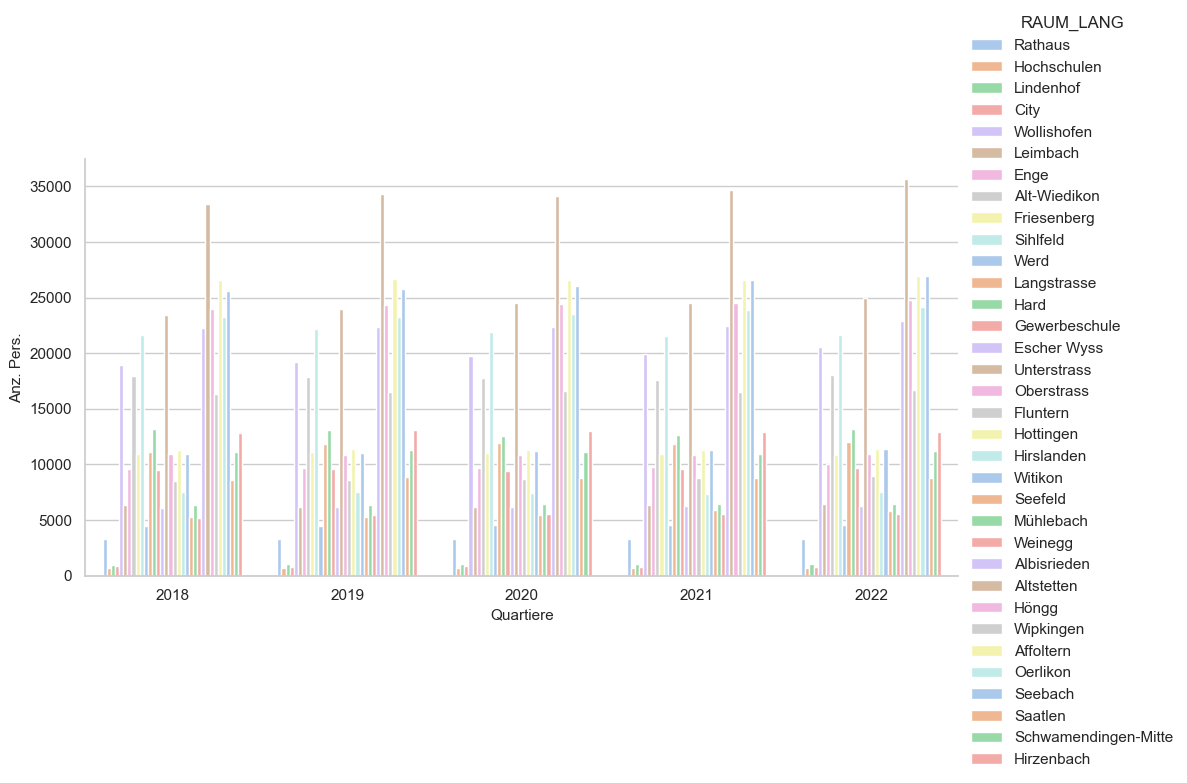

In [ ]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr"
            , y="sum_WBev"
            , hue="RAUM_LANG"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().sort_values("RAUM_CODE", ascending=True)
           )
myHist.set_xlabels('Quartiere', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


#### Facet Grids

##### Wohnbevölkerung nach Stadtquartier

In [ ]:
myFG = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr','StichtagDatJahr_str', 'RAUM_LANG', 'RAUM_CODE', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('RAUM_my_sort', ascending=True) 

myFG

,,,,,sum_WBev
Jahr,StichtagDatJahr_str,RAUM_LANG,RAUM_CODE,RAUM_my_sort,
1993,1993-12-31,Rathaus,R00011,11,3133
2010,2010-12-31,Rathaus,R00011,11,3099
2018,2018-12-31,Rathaus,R00011,11,3267
2002,2002-12-31,Rathaus,R00011,11,3128
1999,1999-12-31,Rathaus,R00011,11,3104
...,...,...,...,...,...
1995,1995-12-31,Hirzenbach,R00123,123,10995
2009,2009-12-31,Hirzenbach,R00123,123,11610
2002,2002-12-31,Hirzenbach,R00123,123,11434


In [ ]:
faced_grid1 = mypy_dv.plot_sns_facetgrid(
    data = myFG.reset_index()
    ,col = "RAUM_LANG"
    ,hue = "RAUM_LANG"
    ,col_wrap = 6
    ,height = 3
    ,grafiktyp = sns.lineplot
    ,x = "StichtagDatJahr"
    ,xlabel = ''
    ,y = "sum_WBev"
    ,ylabel= "Anzahl Personen"
    ,warning_status ="ignore"
    ,myTitle="Bevölkerungsentwicklung pro Statistischem Quartier, seit "+str(data2betested.index.year.min())
)
faced_grid1

In [ ]:
grafic_name = package_name+"_fg_statQuart_zeit_"+date_today+".png"

print('grafiken_testing/'+grafic_name)


faced_grid1.savefig('grafiken_testing/'+grafic_name)

grafiken_testing/BEV324OD3241_fg_statZone_zeit__2024-05-28.png


##### Wohnbevölkerung nach Alter und Zivilstand

**Hinweis**: Eine Gruppierung in Altersgruppen (z.B. wie bisher AlterV10 Zehnjahresgruppen) wäre hier sinnvoll. Da es keine numerischen Codes gibt, ist eine eigene Altersgruppe zu erstellen etwas mühsam...

In [ ]:
myFG2 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr','StichtagDatJahr', 'ALT_LANG', 'ALT_CODE', 'ZIV_LANG', 'ZIV_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('ALT_CODE', ascending=True) 

myFG2.head(2)

,,,,,,sum_WBev
Jahr,StichtagDatJahr,ALT_LANG,ALT_CODE,ZIV_LANG,ZIV_CODE,
1993,1993-12-31,0 Jahre alt,ALT0000,Ledig,ZIV0001,3291
2001,2001-12-31,0 Jahre alt,ALT0000,Ledig,ZIV0001,3300


In [ ]:
faced_grid2 = mypy_dv.plot_sns_facetgrid(
    data = myFG2.reset_index().sort_values('ALT_CODE', ascending=True)
    ,col = "ALT_LANG"
    ,hue = "ZIV_LANG"
    ,col_wrap = 6
    ,height = 3
    ,grafiktyp = sns.lineplot
    ,x = "StichtagDatJahr"
    ,xlabel = ''
    ,y = "sum_WBev"
    ,ylabel= "Anzahl Personen"
    ,warning_status ="ignore"
    ,myTitle="Bevölkerungsentwicklung pro Statistischem Quartier, seit "+str(data2betested.index.year.min())
)
faced_grid2

In [ ]:
grafic_name = package_name+"_fg_alter_ziv_zeit_"+date_today+".png"

print('grafiken_testing/'+grafic_name)


faced_grid2.savefig('grafiken_testing/'+grafic_name)

grafiken_testing/BEV324OD3241_fg_statZone_zeit__2024-05-28.png


### Daten in interaktiver Treemap zeigen

In [ ]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'ALT_LANG', 'ALT_CODE', 'SEX_LANG',
       'SEX_CODE', 'ZIV_LANG', 'ZIV_CODE', 'BEW', 'KREISEZH_LANG', 'KREISEZH_CODE',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [ ]:
myTM = data2betested.loc['2020':data_max_date]  \
    .groupby(['StichtagDatJahr', 'SEX_LANG','SEX_CODE', 'ZIV_LANG', 'ZIV_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

In [ ]:
treeMap1 = mypy_dv.plot_px_treemap(
    data=myTM.reset_index()
    ,levels=["StichtagDatJahr", "SEX_LANG", "ZIV_LANG"]
    ,values="sum_WBev"
    ,color="ZIV_LANG"
    ,myHeaderTitle="Wohnbevölkerung nach Zivilstand und Geschlecht, 2020 - "+data_max_date
    ,color_discrete_map={'(?)':'lightgrey', 'Wohnen':'lightblue'}                
    #,margin_val_bottom=25
)
treeMap1


In [ ]:
grafic_name = package_name+"_tm_jahr_sex_ziv_"+date_today+".png"
print(grafic_name)

treeMap1.write_image('grafiken_testing/'+grafic_name)

In [ ]:
myTM2 = data2betested.loc[data_max_date]  \
    .groupby(['StichtagDatJahr', 'SEX_LANG','SEX_CODE', 'ZIV_LANG', 'ZIV_CODE','KREISEZH_LANG']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

In [ ]:
treeMap2 = mypy_dv.plot_px_treemap(
    data=myTM2.reset_index()
    ,levels=["KREISEZH_LANG", "ZIV_LANG","SEX_LANG"]
    ,values="sum_WBev"
    ,color="ZIV_LANG"
    ,color_discrete_map={'(?)':'lightgrey', 'Wohnen':'lightblue'}                
    ,myHeaderTitle="Wohnbevölkerung nach Stadtkreis, Zivilstand und Geschlecht, "+data_max_date
)
treeMap2


In [ ]:
grafic_name = package_name+"_tm2_kreis_ziv_sex"+date_today+".png"
print(grafic_name)

treeMap2.write_image('grafiken_testing/'+grafic_name)

## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/OGD%20Metadaten.aspx#InplviewHasheb69a2c0-ed94-4ef2-91a5-3b19f038e442=FilterField1%3DMetadaten%255Fx002d%255FPublikations%255Fx00-FilterValue1%3DINT)